In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

!unzip "UCI HAR Dataset.zip"


--2025-09-20 10:02:32--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘UCI HAR Dataset.zip’

UCI HAR Dataset.zip     [   <=>              ]  58.17M  97.0MB/s    in 0.6s    

2025-09-20 10:02:32 (97.0 MB/s) - ‘UCI HAR Dataset.zip’ saved [60999314]

Archive:  UCI HAR Dataset.zip
   creating: UCI HAR Dataset/
  inflating: UCI HAR Dataset/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/UCI HAR Dataset/
  inflating: __MACOSX/UCI HAR Dataset/._.DS_Store  
  inflating: UCI HAR Dataset/activity_labels.txt  
  inflating: __MACOSX/UCI HAR Dataset/._activity_labels.txt  
  inflating: UCI HAR Dataset/features.txt  
  inflating: __MACOSX/UCI HAR Dataset/._features.txt  
  inflating: UCI HAR Dataset/features_info.t

# CNN BiLSTM model

In [2]:
# pytorch_har_conv_bilstm_full.py
import os
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# ---------------------------
# Dataset / constants
# ---------------------------
INPUT_SIGNAL_TYPES = [
    "body_acc_x_","body_acc_y_","body_acc_z_",
    "body_gyro_x_","body_gyro_y_","body_gyro_z_",
    "total_acc_x_","total_acc_y_","total_acc_z_"
]

LABELS = [
    "WALKING","WALKING_UPSTAIRS","WALKING_DOWNSTAIRS",
    "SITTING","STANDING","LAYING"
]

TRAIN = "train/"
TEST = "test/"
DATASET_PATH = "UCI HAR Dataset/"

def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        with open(signal_type_path, 'r') as file:
            series = [np.array(row.replace('  ', ' ').strip().split(' '), dtype=np.float32) for row in file]
        X_signals.append(series)
    X = np.transpose(np.array(X_signals), (1, 2, 0))  # (n_examples, n_steps, n_signals)
    return X

def load_y(y_path):
    with open(y_path, 'r') as file:
        y_ = np.array([row.replace('  ', ' ').strip().split(' ') for row in file], dtype=np.int32)
    return (y_ - 1).reshape(-1)

X_train_signals_paths = [DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths  = [DATASET_PATH + TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path  = DATASET_PATH + TEST  + "y_test.txt"

X_train = load_X(X_train_signals_paths)
X_test  = load_X(X_test_signals_paths)
y_train = load_y(y_train_path)
y_test  = load_y(y_test_path)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape, "y_test.shape:", y_test.shape)

training_data_count = len(X_train)  # 7352
test_data_count = len(X_test)       # 2947
n_steps = X_train.shape[1]          # 128
n_input = X_train.shape[2]          # 9

# ---------------------------
# Hyperparameters
# ---------------------------
n_hidden = 64          # increased capacity (was 32)
n_classes = 6

learning_rate = 0.0025
weight_decay_val = 1e-4     # AdamW weight decay
epochs = 300
batch_size = 1500
display_iter = 30000

# warmup + scheduler params
warmup_steps = 1000
warmup_start_lr = 1e-6
eta_min = 1e-5               # cosine minimum LR
grad_clip = 5.0
dropout_prob = 0.25

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ---------------------------
# Model: conv front-end -> BiLSTM -> LayerNorm -> Dropout -> FC
# ---------------------------
class HARConvBiLSTM(nn.Module):
    def __init__(self, n_input, n_hidden, n_classes, n_layers=2, dropout=0.25):
        super().__init__()
        # Conv front-end: input channels = sensors, operate over time
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_input, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=n_hidden, kernel_size=3, padding=1),
            nn.ReLU()
        )
        # BiLSTM: input_size = n_hidden (from conv), hidden_size = n_hidden
        self.lstm = nn.LSTM(input_size=n_hidden, hidden_size=n_hidden,
                            num_layers=n_layers, batch_first=True, bidirectional=True)
        self.layernorm = nn.LayerNorm(n_hidden * 2)
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(n_hidden * 2, n_classes)

    def forward(self, x):
        # x: (batch, time, features)
        x = x.permute(0, 2, 1)               # -> (batch, features, time) for Conv1d
        x = self.conv(x)                     # -> (batch, n_hidden, time)
        x = x.permute(0, 2, 1)               # -> (batch, time, n_hidden)
        out_seq, _ = self.lstm(x)            # -> (batch, time, n_hidden*2)
        last = out_seq[:, -1, :]             # take last timestep
        last = self.layernorm(last)
        last = self.dropout(last)
        logits = self.out(last)
        return logits

model = HARConvBiLSTM(n_input, n_hidden, n_classes, n_layers=2, dropout=dropout_prob).to(device)

# ---------------------------
# Improved initialization (conv, LSTM gated init, biases forget=1, out linear)
# ---------------------------
def init_weights(m):
    # conv layers: kaiming for ReLU
    if isinstance(m, nn.Conv1d):
        init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        # final out linear
        if m is model.out:
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
        else:
            init.xavier_uniform_(m.weight)
            if m.bias is not None:
                init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        # initialize LSTM weights gate-wise
        for name, param in m.named_parameters():
            if 'weight_ih' in name:
                init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                # param shape: (4*H, H) or similar. Initialize each gate block orthogonally
                sz = param.data.size()
                if len(sz) == 2 and sz[0] % 4 == 0 and sz[0] // 4 == sz[1]:
                    H = sz[1]
                    for i in range(4):
                        init.orthogonal_(param.data[i*H:(i+1)*H])
                else:
                    init.orthogonal_(param.data)
            elif 'bias' in name:
                init.zeros_(param.data)
                # set forget gate bias to 1 (for both bias_ih and bias_hh if present)
                hidden_size = m.hidden_size
                if param.data.numel() == 4 * hidden_size:
                    start = hidden_size
                    end = 2 * hidden_size
                    param.data[start:end].fill_(1.0)

# reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

model.apply(init_weights)

# ---------------------------
# Loss, optimizer, scheduler (warmup handled manually)
# ---------------------------
criterion = nn.CrossEntropyLoss()  # could add class weights if needed
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_val)

max_steps = math.ceil((training_data_count * epochs) / batch_size)
cosine_T_max = max(1, max_steps - warmup_steps)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_T_max, eta_min=eta_min)

def apply_warmup_lr(step):
    if step <= warmup_steps:
        lr = warmup_start_lr + (learning_rate - warmup_start_lr) * (step / float(max(1, warmup_steps)))
        for g in optimizer.param_groups:
            g['lr'] = lr
        return True
    return False

# ---------------------------
# Helper: wrap-around batch extraction (keeps behavior identical)
# ---------------------------
def extract_batch(X, y, global_step, batch_size):
    shape = list(X.shape)
    shape[0] = batch_size
    batch = np.empty(shape, dtype=np.float32)
    batch_y = np.empty((batch_size,), dtype=np.int64)
    total = len(X)
    for i in range(batch_size):
        index = ((global_step - 1) * batch_size + i) % total
        batch[i] = X[index]
        batch_y[i] = y[index]
    return batch, batch_y

# ---------------------------
# Training loop (records metrics + LR)
# ---------------------------
train_losses, train_accuracies, train_steps = [], [], []
test_losses, test_accuracies, test_steps = [], [], []
lrs, lr_steps = [], []

X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

step = 1
print("Total training steps (approx):", max_steps)

best_test_acc = 0.0
best_model_path = "best_har_model.pth"

while step <= max_steps:
    batch_x_np, batch_y_np = extract_batch(X_train, y_train, step, batch_size)
    batch_x = torch.tensor(batch_x_np, dtype=torch.float32).to(device)
    batch_y = torch.tensor(batch_y_np, dtype=torch.long).to(device)

    model.train()
    optimizer.zero_grad()
    logits = model(batch_x)
    loss = criterion(logits, batch_y)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
    optimizer.step()

    # scheduler or warmup update: warmup for first warmup_steps, then cosine scheduler
    if apply_warmup_lr(step):
        pass
    else:
        scheduler.step()

    # record LR
    current_lr = optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    lr_steps.append(step * batch_size)

    # training accuracy
    preds = torch.argmax(logits, dim=1)
    acc = (preds == batch_y).float().mean().item()

    current_iter = step * batch_size
    train_losses.append(loss.item())
    train_accuracies.append(acc)
    train_steps.append(current_iter)

    # evaluate occasionally like the original
    if (step == 1) or ((current_iter) % display_iter == 0) or (step >= max_steps):
        print(f"Training iter #{current_iter}:   Batch Loss = {loss.item():.6f}, Acc = {acc:.6f}, LR = {current_lr:.3e}")

        model.eval()
        with torch.no_grad():
            test_logits = model(X_test_t)
            test_loss = criterion(test_logits, y_test_t)
            test_preds = torch.argmax(test_logits, dim=1)
            test_acc = (test_preds == y_test_t).float().mean().item()

        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc)
        test_steps.append(current_iter)

        print(f"PERFORMANCE ON TEST SET: Batch Loss = {test_loss.item():.6f}, Accuracy = {test_acc:.6f}")

        # Save the model if it has the best test accuracy so far
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved best model with accuracy: {best_test_acc:.6f}")


    step += 1

print("Optimization Finished!")

# ---------------------------
# Final test evaluation
# ---------------------------
model.eval()
with torch.no_grad():
    final_logits = model(X_test_t)
    final_loss = criterion(final_logits, y_test_t)
    final_preds = torch.argmax(final_logits, dim=1)
    final_acc = (final_preds == y_test_t).float().mean().item()

print("FINAL RESULT: Batch Loss = {:.6f}, Accuracy = {:.6f}".format(final_loss.item(), final_acc))

X_train.shape: (7352, 128, 9)
X_test.shape: (2947, 128, 9)
y_train.shape: (7352,) y_test.shape: (2947,)
Using device: cuda
Total training steps (approx): 1471
Training iter #1500:   Batch Loss = 3.014992, Acc = 0.160667, LR = 3.499e-06
PERFORMANCE ON TEST SET: Batch Loss = 2.070259, Accuracy = 0.196810
Saved best model with accuracy: 0.196810
Training iter #30000:   Batch Loss = 1.891607, Acc = 0.254000, LR = 5.098e-05
PERFORMANCE ON TEST SET: Batch Loss = 1.592382, Accuracy = 0.422464
Saved best model with accuracy: 0.422464
Training iter #60000:   Batch Loss = 1.250087, Acc = 0.536667, LR = 1.010e-04
PERFORMANCE ON TEST SET: Batch Loss = 1.100260, Accuracy = 0.609094
Saved best model with accuracy: 0.609094
Training iter #90000:   Batch Loss = 0.922593, Acc = 0.638667, LR = 1.509e-04
PERFORMANCE ON TEST SET: Batch Loss = 0.820107, Accuracy = 0.682050
Saved best model with accuracy: 0.682050
Training iter #120000:   Batch Loss = 0.688067, Acc = 0.734667, LR = 2.009e-04
PERFORMANCE ON 

In [3]:
# Load the best model
best_model = HARConvBiLSTM(n_input, n_hidden, n_classes, n_layers=2, dropout=dropout_prob).to(device)
best_model.load_state_dict(torch.load("best_har_model.pth"))

# Evaluate the best model on the test set
best_model.eval()
with torch.no_grad():
    best_test_logits = best_model(X_test_t)
    best_test_preds = torch.argmax(best_test_logits, dim=1)
    best_test_acc = (best_test_preds == y_test_t).float().mean().item()

print("Best Model Test Accuracy: {:.2f}%".format(100.0 * best_test_acc))

Best Model Test Accuracy: 93.38%


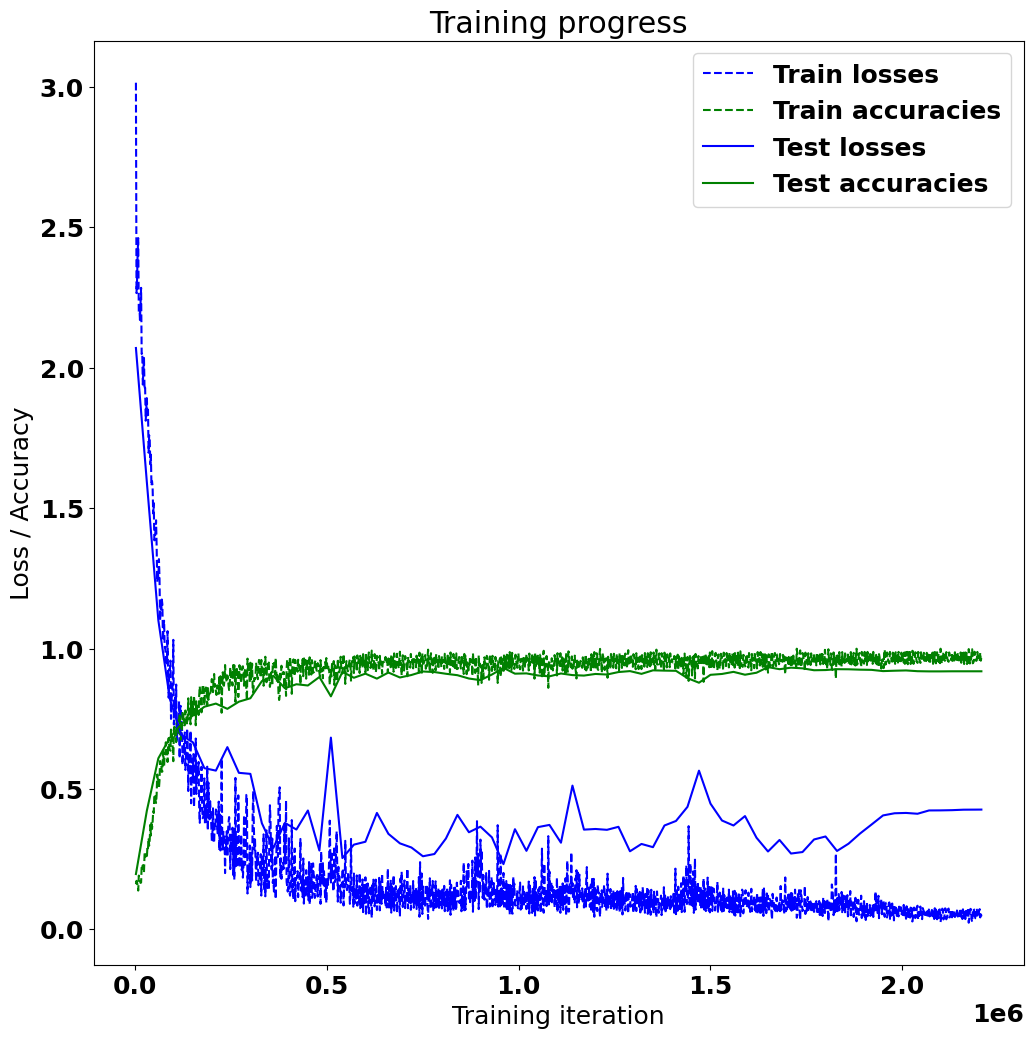

In [9]:
# ---------------------------
# Plotting: training curves + LR
# ---------------------------
# Matplotlib font/style matching your snippet
plt.rcParams.update({'font.family': 'DejaVu Sans', 'font.weight': 'bold', 'font.size': 18})

plt.figure(figsize=(12, 12))
plt.plot(train_steps, train_losses, "b--", label="Train losses")
plt.plot(train_steps, train_accuracies, "g--", label="Train accuracies")
if len(test_steps) > 0:
    plt.plot(test_steps, test_losses, "b-", label="Test losses")
    plt.plot(test_steps, test_accuracies, "g-", label="Test accuracies")
plt.title("Training progress")
plt.xlabel("Training iteration")
plt.ylabel("Loss / Accuracy")
plt.legend()
plt.show()





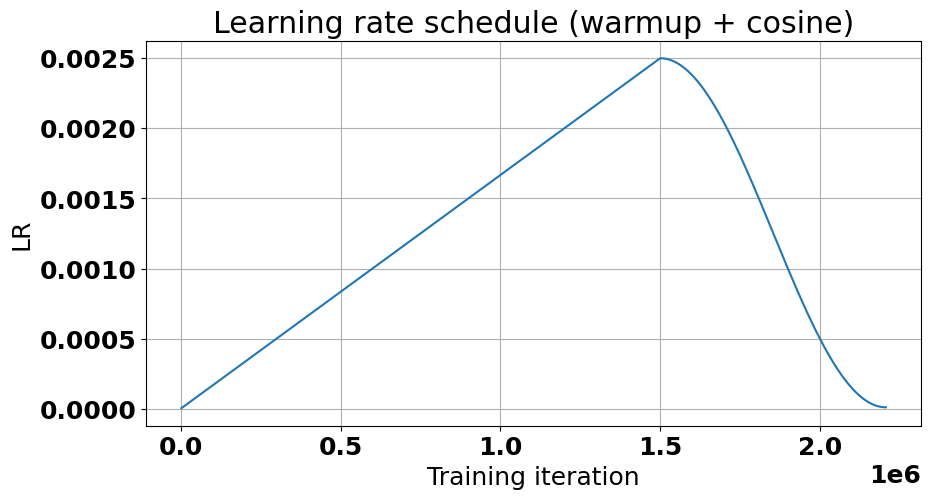

In [8]:
plt.figure(figsize=(10,5))
plt.plot(lr_steps, lrs, label="learning rate")
plt.title("Learning rate schedule (warmup + cosine)")
plt.xlabel("Training iteration")
plt.ylabel("LR")
plt.grid(True)
plt.show()

Testing Accuracy: 91.89%
Precision: 92.03%
Recall: 91.89%
F1 score: 91.86%
Confusion Matrix:
 [[475   2  19   0   0   0]
 [  0 455  16   0   0   0]
 [  0  17 403   0   0   0]
 [  1  25   0 416  49   0]
 [  1   5   0 104 422   0]
 [  0   0   0   0   0 537]]


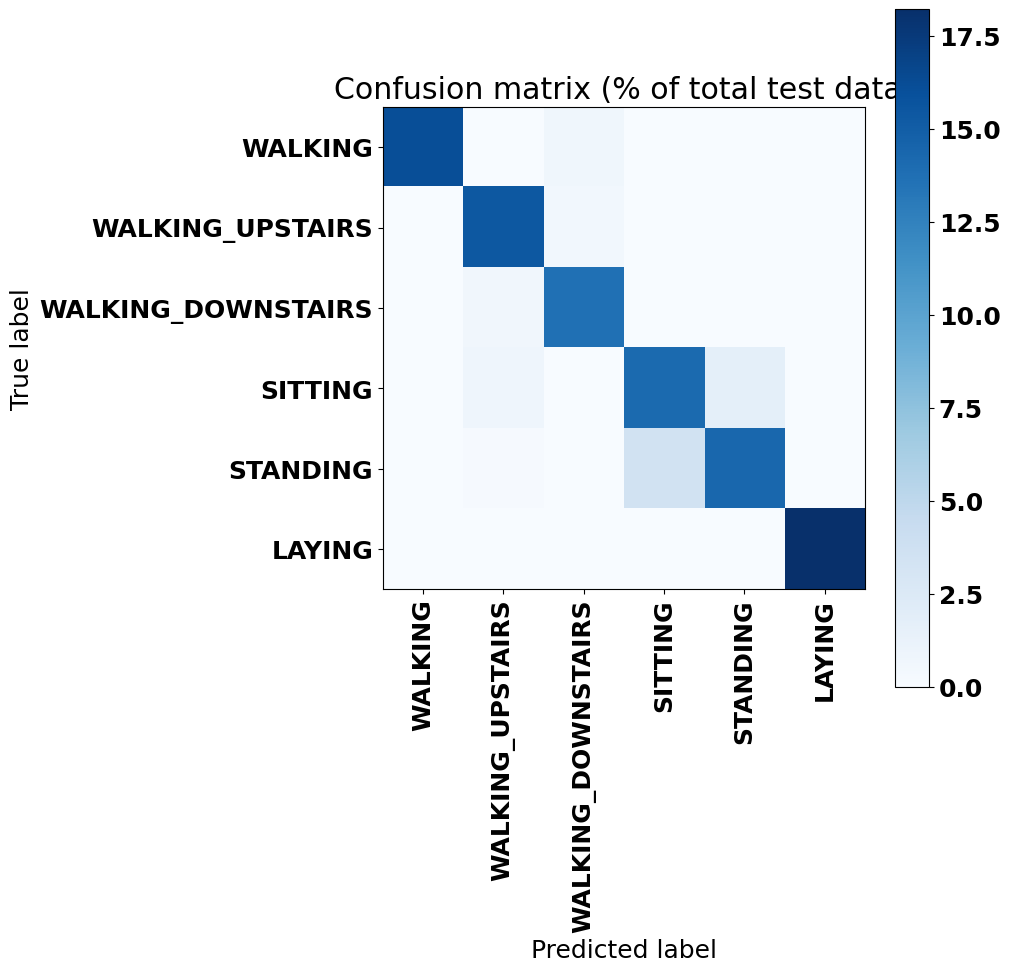

In [7]:
# ---------------------------
# Metrics & confusion matrix
# ---------------------------
final_logits_cpu = final_logits.detach().cpu().numpy()
predictions = np.argmax(final_logits_cpu, axis=1)
y_true = np.array(y_test).reshape(-1)

print("Testing Accuracy: {:.2f}%".format(100.0 * metrics.accuracy_score(y_true, predictions)))
print("Precision: {:.2f}%".format(100.0 * metrics.precision_score(y_true, predictions, average="weighted")))
print("Recall: {:.2f}%".format(100.0 * metrics.recall_score(y_true, predictions, average="weighted")))
print("F1 score: {:.2f}%".format(100.0 * metrics.f1_score(y_true, predictions, average="weighted")))

cm = confusion_matrix(y_true, predictions)
print("Confusion Matrix:\n", cm)
cm_norm = cm.astype(np.float32) / cm.sum() * 100.0
plt.figure(figsize=(10,10))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues) # Changed colormap to Blues
plt.title("Confusion matrix (% of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()